In [1]:
# 순차구조

import functools
import operator
from datetime import datetime
from typing import Sequence, Annotated, Literal
from typing_extensions import TypedDict

from dotenv import load_dotenv
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, load_prompt
from langchain_core.runnables import RunnableConfig
from langchain_core.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import stream_graph
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel
import uuid
import asyncio
import sys


In [2]:
# --- 로컬 모듈 임포트 ---
# (실제 환경에 맞게 경로를 확인하거나 수정해야 할 수 있습니다.)
from manse_8 import calculate_saju_tool
from pdf_retriever_saju import pdf_rag_chain, compression_retriever
from query_expansion_agent import get_query_expansion_node, get_query_expansion_agent

# --- 환경 변수 로드 ---
load_dotenv()

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- LLM 및 기본 설정 ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
# --- 1. Retriever 및 관련 도구 설정 ---
pdf_retriever = compression_retriever()
pdf_chain = pdf_rag_chain()

retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "A tool for searching information related to Saju (Four Pillars of Destiny)",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)
retriever_tools = [retriever_tool]


In [4]:

# --- 2. Agent 생성 ---

# Manse Tool Agent
manse_tools = [calculate_saju_tool]
manse_tool_agent = create_react_agent(llm, manse_tools)

# Retriever Tool Agent
base_prompt = load_prompt("prompt/saju-rag-promt_2.yaml")
saju_prompt = ChatPromptTemplate.from_messages([
    ("system", f"Today is {now}"),
    ("system", base_prompt.template),
    MessagesPlaceholder("messages"),
])

retriever_tool_agent = create_react_agent(llm, retriever_tools, prompt=saju_prompt).with_config({"tags": ["final_answer_agent"]})

# Web Search Tool Agent
tavily_tool = TavilySearch(max_results=2, include_domains=["namu.wiki", "wikipedia.org"])
duck_tool = DuckDuckGoSearchResults(max_results=2)
web_search_tools = [tavily_tool, duck_tool]
web_search_prompt = "사주 또는 사주 오행의 개념적 질문이나, 일상 질문이 들어오면, web search를 통해 답합니다."
web_tool_agent = create_react_agent(llm, tools=web_search_tools, prompt=web_search_prompt).with_config({"tags": ["final_answer_agent"]})

# General QA Tool Agent
@tool
def general_qa_tool(query: str) -> str:
    """
    일반적인 질문이나 상식적인 내용에 대해 답변합니다. 사주와 관련 없는 모든 질문에 사용할 수 있습니다.
    """
    google_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    return google_llm.invoke(query)

general_qa_tools = [general_qa_tool]
general_qa_prompt = "일반적인 질문이나 상식적인 내용에 대해 답변합니다."
general_qa_agent = create_react_agent(llm, tools=general_qa_tools, prompt=general_qa_prompt).with_config({"tags": ["final_answer_agent"]})

# Query Expansion Agent
query_expansion_node = get_query_expansion_node()


In [5]:
# --- 3. Agent 상태 및 노드 정의 ---

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

def agent_node(state, agent, name):
    agent_response = agent.invoke(state)
    return {"messages": [HumanMessage(content=agent_response["messages"][-1].content, name=name)]}

manse_tool_agent_node = functools.partial(agent_node, agent=manse_tool_agent, name="ManseTool")
retriever_tool_agent_node = functools.partial(agent_node, agent=retriever_tool_agent, name="RetrieverTool")
web_tool_agent_node = functools.partial(agent_node, agent=web_tool_agent, name="WebTool")
general_qa_agent_node = functools.partial(agent_node, agent=general_qa_agent, name="GeneralQA")

# --- 4. Supervisor Agent 정의 ---
members = ["SajuExpert", "WebTool", "GeneralQA"]
options_for_next = ["FINISH"] + members

class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

# --- 현재 날짜
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

supervisor_system_prompt = (
    "오늘 날짜는 {now}입니다.\n"
    "당신은 다음과 같은 전문 에이전트들을 조율하는 Supervisor입니다: {members}.\n"
    "각 에이전트의 역할은 다음과 같습니다:\n"
    "- SajuExpert: 사주(생년월일/시간 등) 정보를 바탕으로 사주풀이, 운세 해석, 상세 분석을 담당합니다. "
        " 추가적인 질문으로 내일, 다음달 내년등 미래에 대한 운세를 물어볼때도 SajuExpert를 호출하세요. "
        " 이때 이전 사주구조를 사용해야 하며, 미래의 운세는 현재의 기준으로({now}) 나의 내일, 다음달, 내년 운세를 말합니다.\n"
        " 이때 특별한 요청이 있지 않는이상, 이전에 사용했던 사주구조, 천간지지, 오핸분석을 그대로 사용해야 합니다.\n"
    "- WebTool: 사주 개념, 오행 등 일반적/개념적 질문이나 일상 질문에 대해 웹 검색을 통해 답변합니다.\n"
    "- GeneralQA: 사주와 무관한 일반 상식, 과학, 프로그래밍 등 모든 질문에 답변합니다.\n\n"
    "당신의 임무는 사용자의 요청을 가장 적합한 에이전트에게 라우팅하는 것입니다.\n"
    "다음 기준을 따르세요:\n"
    "1. 사용자 입력에 생년월일, 출생시간 등 사주풀이에 필요한 정보가 포함되어 있거나,"
    " 추가적인 운세/사주풀이, 또는 내일, 다음달 내년등 미래에 대한 운세를(예: 내일 운세알려줘, 다음달 운세 알려줘 등등) 요청하면 SajuExpert를 호출하세요. 이때 현재의 기준으로({now}) 나의 내일, 다음달, 내년 운세를 말합니다.\n"
    " 이때 특별한 요청이 있지 않는이상, 이전에 사용했던 사주구조를 사용해야 합니다."
    "2. 사주에 대한 개념적/일반적 질문(예: '사주란 무엇인가요?')이나 일상 질문은 WebTool을 호출하세요.\n"
    "3. 사주와 전혀 관련 없는 질문은 GeneralQA를 호출하세요.\n"
    "4. **이전 대화(최근 assistant의 답변)가 SajuExpert(만세툴)에서 나온 것이고, 이번 질문이 그에 대한 추가 질문(예: '그럼 건강운은?', '재물운은?')이라면, 반드시 SajuExpert로 라우팅하세요.**\n"
    "5. 대화의 맥락을 고려하여, 사용자가 명시적으로 사주풀이를 요청하지 않아도, 직전 대화가 사주풀이였다면 추가 질문도 SajuExpert로 보내세요.\n"
    "에이전트가 답변을 마치면 FINISH로 응답하세요."
)

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "위 대화를 참고하여, 다음 중 누가 다음 행동을 해야 하는지 선택하세요: {options}"),
    ]
)

def supervisor_agent(state):
    supervisor_chain = (
        supervisor_prompt.partial(options=str(options_for_next), members=", ".join(members), now=now)
        | llm.with_structured_output(RouteResponse)
    )
    route_response = supervisor_chain.invoke(state)
    return {"next": route_response.next}


In [6]:
# LLM 분기 프롬프트
branch_prompt = ChatPromptTemplate.from_messages([
    ("system", "다음 중 어디로 가야 할지 판단하세요: 'saju_chat' 또는 'retriever'.\n"
               "사주풀이에 추가 설명이 필요하면 'saju_chat', 생년월일을 입력받으면 'retriever'를 선택하세요.\n"
               "반드시 하나만 골라주세요.\n"),
    ("user", "질문: {user_input}\n"
             "manse 결과: {manse_result}\n"
             "어디로 가야 합니까? (saju_chat/retriever 중 하나만 답변)")
])

def llm_branch_decision(state):
    user_input = ""
    manse_result = ""
    # state에서 user_input, manse_result 추출 (구조에 따라 조정)
    if state.get("messages"):
        # messages가 리스트인지 문자열인지 확인
        if isinstance(state["messages"], list) and len(state["messages"]) > 0:
            # 첫 번째 메시지가 HumanMessage 객체인 경우
            if hasattr(state["messages"][0], 'content'):
                user_input = state["messages"][0].content
            else:
                user_input = str(state["messages"][0])
            
            # 마지막 메시지가 AIMessage 객체인 경우
            if hasattr(state["messages"][-1], 'content'):
                manse_result = state["messages"][-1].content
            else:
                manse_result = str(state["messages"][-1])
        else:
            # messages가 문자열인 경우
            user_input = str(state["messages"])
            manse_result = ""
    
    prompt = branch_prompt.format(user_input=user_input, manse_result=manse_result)
    # LLM 호출
    result = llm.invoke(prompt)
    # 결과에서 'saju_chat' 또는 'retriever'만 추출
    if "retriever" in result.content.lower():
        return "retriever"
    return "saju_chat"

In [7]:
@tool
def saju_chat_tool(state):
    """
    사주에 대한 대화형 챗봇 답변을 생성합니다. 간단하게 답변해주세요.
    """
    last_msg = state["messages"][-1].content
    response = "(사주 대화 결과: 추가 질문에 대한 답변)"
    return {"messages": state["messages"] + [HumanMessage(content=response, name="SajuChat")]}

saju_chat_tools = [saju_chat_tool]
saju_chat_prompt = "사주 대화 결과를 참고하여 추가 질문에 대한 답변을 생성합니다. 내일의 운세, 내년의 운세등을 대화형식으로 답변합니다."
saju_chat_agent = create_react_agent(llm, saju_chat_tools, prompt=saju_chat_prompt)
saju_chat_node = functools.partial(agent_node, agent=saju_chat_agent, name="SajuChat")

def create_workflow_graph():
    """워크플로우 그래프 생성 (병렬 구조)"""
    # SajuExpert Sub-graph 생성 (병렬)
    saju_expert_workflow = StateGraph(AgentState)
    saju_expert_workflow.add_node("manse", manse_tool_agent_node)
    saju_expert_workflow.add_node("saju_chat", saju_chat_node)
    saju_expert_workflow.add_node("retriever", retriever_tool_agent_node)


    saju_expert_workflow.add_edge(START, "manse")
    saju_expert_workflow.add_conditional_edges(
        "manse",
        llm_branch_decision,
        {
            "saju_chat": "saju_chat",
            "retriever": "retriever"
        }
    )
    saju_expert_workflow.add_edge("saju_chat", END)
    saju_expert_workflow.add_edge("retriever", END)
    saju_expert_graph = saju_expert_workflow.compile(MemorySaver())  # 이 부분!

    # 메인 그래프 생성 (기존과 동일)
    workflow = StateGraph(AgentState)
    workflow.add_node("SajuExpert", saju_expert_graph)
    workflow.add_node("QueryExpansion", query_expansion_node)
    workflow.add_node("WebTool", web_tool_agent_node)
    workflow.add_node("GeneralQA", general_qa_agent_node)
    workflow.add_node("Supervisor", supervisor_agent)

    for member in members:
        workflow.add_edge(member, "Supervisor")

    conditional_map = {k: k for k in members}
    conditional_map["FINISH"] = END

    def get_next(state):
        return state["next"]

    workflow.add_conditional_edges("Supervisor", get_next, conditional_map)
    workflow.add_edge(START, "QueryExpansion")
    workflow.add_edge("QueryExpansion", "Supervisor")

    return workflow.compile(checkpointer=MemorySaver())


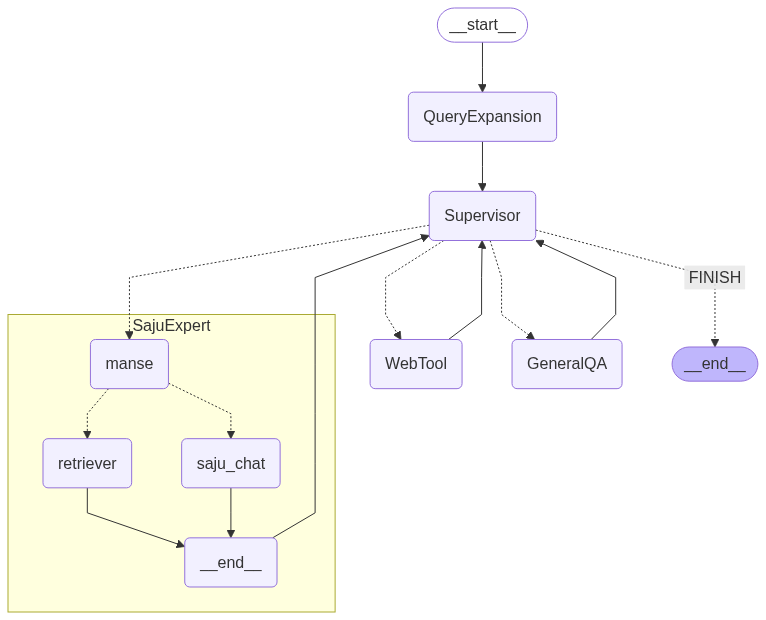

In [8]:
from IPython.display import display, Image
Image(create_workflow_graph().get_graph(xray=True).draw_mermaid_png())

In [9]:

from langchain_teddynote.messages import random_uuid, stream_graph, invoke_graph
from langchain_core.messages import AIMessage

# --- 6. 스크립트 실행 (스트리밍 로직 수정) ---
def run_saju_analysis(messages, thread_id=None, use_stream=True):
    graph = create_workflow_graph()
    if not graph:
        return "그래프 생성에 실패했습니다."
    if thread_id is None:
        thread_id = random_uuid()
    config = RunnableConfig(recursion_limit=10, configurable={"thread_id": thread_id})
    inputs = {"messages": messages}
    if use_stream:
        return stream_graph(graph, inputs, config)
    else:
        return invoke_graph(graph, inputs, config)


In [10]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [ ]:

def main():
    print("사주 에이전틱 RAG 시스템 (대화 맥락 기억 버전)을 시작합니다... ")
    print("생년월일, 태이난 시각, 성별을 입력해 주세요.")
    print("윤달에 태어나신 경우, 윤달이라고 작성해주세요.")
    example_questions = [
        "1996년 12월 13일 남자, 10시 30분 출생 운세봐줘.",
        "대운과 세운, 조심해야 할것들 알려줘",
        "금전운알려줘",
        "정관이 뭐야? 상세히 설명해줘",
        "사주의 개념에 대해서 알려줘"
    ]
    print("\n사용 가능한 예시 질문:")
    for i, question in enumerate(example_questions, 1):
        print(f"{i}. {question}")
    print("\n질문을 입력하세요 (종료하려면 'quit' 입력):")
    chat_history = []
    thread_id = random_uuid()
    while True:
        user_input = input("\n질문: ").strip()
        if user_input.lower() in ['quit', 'exit', '종료']:
            print("시스템을 종료합니다.")
            break
        if not user_input:
            continue
        chat_history.append(HumanMessage(content=user_input))
        try:
            print("\n분석을 시작합니다...")
            result = run_saju_analysis(chat_history, thread_id=thread_id, use_stream=True)
            print("\n분석 완료!")
            # 답변 메시지 추출 및 기록 (AIMessage로 저장)
            if hasattr(result, '__iter__') and not isinstance(result, str):
                # stream_graph의 경우 generator이므로, 마지막 메시지 추출
                last_ai_msg = None
                for msg in result:
                    if hasattr(msg, 'content'):
                        last_ai_msg = msg
                if last_ai_msg:
                    chat_history.append(AIMessage(content=last_ai_msg.content))
            # invoke_graph의 경우는 별도 처리 필요
        except Exception as e:
            print(f"오류가 발생했습니다: {e}")

if __name__ == "__main__":
    main()


In [35]:
# LLM 분기 프롬프트
branch_prompt = ChatPromptTemplate.from_messages([
    ("system", "다음 중 어디로 가야 할지 판단하세요: 'saju_chat' 또는 'retriever'.\n"
               "사주풀이에 추가 설명이 필요하면 'saju_chat', 생년월일을 입력받으면 'retriever'를 선택하세요.\n"
               "반드시 하나만 골라주세요.\n"),
    ("user", "질문: {user_input}\n"
             "manse 결과: {manse_result}\n"
             "어디로 가야 합니까? (saju_chat/retriever 중 하나만 답변)")
])

def llm_branch_decision(state):
    user_input = ""
    manse_result = ""
    # state에서 user_input, manse_result 추출 (구조에 따라 조정)
    if state.get("messages"):
        # messages가 리스트인지 문자열인지 확인
        if isinstance(state["messages"], list) and len(state["messages"]) > 0:
            # 첫 번째 메시지가 HumanMessage 객체인 경우
            if hasattr(state["messages"][0], 'content'):
                user_input = state["messages"][0].content
            else:
                user_input = str(state["messages"][0])
            
            # 마지막 메시지가 AIMessage 객체인 경우
            if hasattr(state["messages"][-1], 'content'):
                manse_result = state["messages"][-1].content
            else:
                manse_result = str(state["messages"][-1])
        else:
            # messages가 문자열인 경우
            user_input = str(state["messages"])
            manse_result = ""
    
    prompt = branch_prompt.format(user_input=user_input, manse_result=manse_result)
    # LLM 호출
    result = llm.invoke(prompt)
    # 결과에서 'saju_chat' 또는 'retriever'만 추출
    if "retriever" in result.content.lower():
        return "retriever"
    return "saju_chat"



In [37]:

# 테스트용 state 생성
test_state = {
    "messages": "1995년 3월 28일 남자 12시 30분"
}

result = llm_branch_decision(test_state)
print(result)

retriever


In [ ]:

# 테스트용 state 생성
test_state = {
    "messages": "1995년 3월 28일 남자 12시 30분"
}

result = llm_branch_decision(test_state)
print(result)

In [38]:

# 테스트용 state 생성
test_state = {
    "messages": "내일운세"
}

result = llm_branch_decision(test_state)
print(result)

saju_chat
